# MNIST example using scivae

Here we just show a simple example of how the data we can encode & predict from the dataset.



In [1]:
import os
import shutil
import tempfile
import unittest
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scivae import Optimiser, VAE, Validate
from sciviso import Scatterplot



# Set the location of the mnist data
data_dir = '../tests/data/mnist/'
image_size = 28
# The more images/data you have the better it will be
num_images = 40000

# Set up the data format (you don't normally need to do this (i.e. a normal np array works best))
test_f = open(f'{data_dir}train-images-idx3-ubyte', 'rb')
test_f.read(16)
buf = test_f.read(image_size * image_size * num_images)
test_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(num_images, image_size * image_size)

# Read in teh training labels
f = open(f'{data_dir}train-labels-idx1-ubyte', 'rb')
f.read(8)
test_labels = []
for i in range(0, len(test_data)):
    buf = f.read(1)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    test_labels.append(labels[0])




2022-12-02 12:03:29.276027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configuration

The configuration is the design of the neural network, it has the following parameters:  

1. loss: this is the metric for the loss function, and it can be: 'mse'=mean squared error (for continuous data), or 'ce' for cross entropy (for binary data)
2. distance_metric: this is the distance metric between the distributions and can either be 'mmd': maximum mean discrepency, or kl: Kullback–Leibler (see this blog for details: https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/)
3. mmd_weight: this is how much you want to force the VAE to learn 
config = {'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 1}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'relu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'relu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adam'}}



In [2]:
# Create a configuration for the dataset
config = {'scale_data': True,
          'loss': {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 1}, 
          'encoding': {'layers': [{'num_nodes': 128, 'activation_fn': 'selu'},
                                  {'num_nodes': 64, 'activation_fn': 'relu'}]}, 
          'decoding': {'layers': [{'num_nodes': 64, 'activation_fn': 'relu'}, 
                                  {'num_nodes': 128, 'activation_fn': 'selu'}]}, 
          'latent': {'num_nodes': 2}, 'optimiser': {'params': {}, 'name': 'adagrad'}}



# Run the VAE 
vae = VAE(test_data, test_data, test_labels, config, 'vae')
# The more epochs you run the better (until some point so would recomend more though it wil take longer)
vae.encode('default', epochs=100, batch_size=1000)
# get the encoded data
encoding = vae.get_encoded_data()

None
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 default_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          100480      ['default_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 128)         512         ['dense[0][0]']                  
 alization)                               

2022-12-02 12:03:34.741418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total params: 113,552
Trainable params: 111,600
Non-trainable params: 1,952
_________________________________________________________________
None
Epoch 1/100
34/34 [==============================] - 5s 80ms/step - loss: 515.0859 - val_loss: 134.2977
Epoch 2/100
34/34 [==============================] - 3s 77ms/step - loss: 232.4563 - val_loss: 108.7989
Epoch 3/100
34/34 [==============================] - 3s 90ms/step - loss: 128.5531 - val_loss: 92.1605
Epoch 4/100
34/34 [==============================] - 3s 90ms/step - loss: 85.4033 - val_loss: 80.4918
Epoch 5/100
34/34 [==============================] - 3s 89ms/step - loss: 70.5240 - val_loss: 72.1864
Epoch 6/100
34/34 [==============================] - 3s 102ms/step - loss: 61.8096 - val_loss: 66.2642
Epoch 7/100
34/34 [==============================] - 3s 98ms/step - loss: 58.2141 - val_loss: 61.9206
Epoch 8/100
34/34 [==============================] - 4s 107ms/step - loss: 55.3495 - val_loss: 58.7390
Epoch 9/100
34/34 [===========

34/34 [==============================] - 6s 179ms/step - loss: 40.0107 - val_loss: 40.0050
Epoch 79/100
34/34 [==============================] - 6s 176ms/step - loss: 40.1385 - val_loss: 40.3997
Epoch 80/100
34/34 [==============================] - 5s 147ms/step - loss: 39.9575 - val_loss: 40.0003
Epoch 81/100
34/34 [==============================] - 5s 153ms/step - loss: 39.8755 - val_loss: 39.9090
Epoch 82/100
34/34 [==============================] - 5s 156ms/step - loss: 39.8581 - val_loss: 40.1319
Epoch 83/100
34/34 [==============================] - 6s 169ms/step - loss: 39.8210 - val_loss: 39.8829
Epoch 84/100
34/34 [==============================] - 5s 159ms/step - loss: 39.7819 - val_loss: 39.8933
Epoch 85/100
34/34 [==============================] - 6s 172ms/step - loss: 39.7008 - val_loss: 39.8914
Epoch 86/100
34/34 [==============================] - 6s 172ms/step - loss: 39.6712 - val_loss: 39.8074
Epoch 87/100
34/34 [==============================] - 6s 183ms/step - loss: 3

In [3]:
encoding = vae.get_encoded_data()

## Visualise the reconstruction


Have a look at how good the reconstruction is from the latent space.

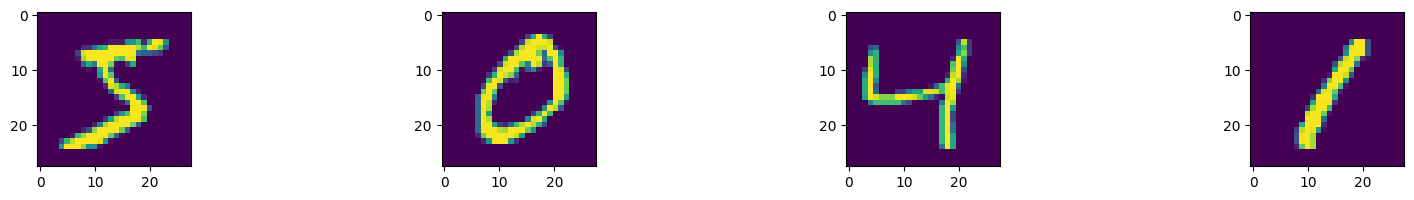

1250/1250 [==============================] - 3s 2ms/step


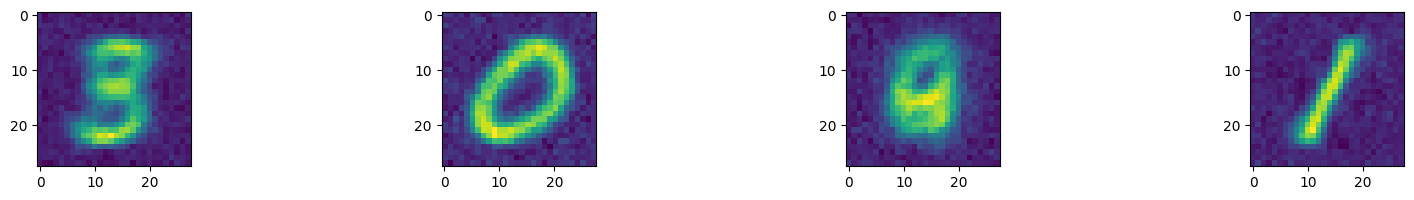

In [4]:
from sklearn.preprocessing import MinMaxScaler


# Show some of the images (4)
n = 4

# Show the true data
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))

plt.show()
# Ensure we're encoding and decoding the same dataset
scaler = MinMaxScaler(copy=True)
test_data_scaled = scaler.fit_transform(test_data)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)

encoding = vae.encode_new_data(test_data_scaled)
# Show the prediction of the test data (i.e. using the test data how does it get reconstructed)
d = vae.decoder.predict(encoding)
plt.figure(figsize=(20, 2))
n = 4
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(d[i,:].reshape(28, 28))

plt.show()

## Visualise the latent space

Here we can have a look at the latent space by simply plotting the latent space & looking at how our labels separate.

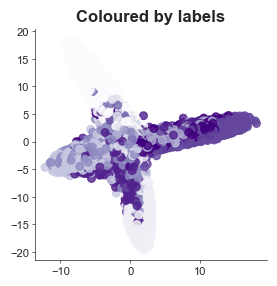

In [5]:
# Plot the latent space - have a look at the first two latent nodes
vis_df = pd.DataFrame()
vis_df['latent_0'] = encoding[:, 0]
vis_df['latent_1'] = encoding[:, 1]
vis_df['test_label'] = test_labels


# Zip the colours to make the labels into numeric values
lut = dict(zip(set(test_labels), sns.color_palette("Set1", len(set(test_labels)))))
row_colors2 = pd.DataFrame(test_labels)[0].map(lut)
vis_df['label'] = row_colors2
scatter = Scatterplot(vis_df, 'latent_0', 'latent_1',  
                      colour=vis_df['test_label'].values, title='Coloured by labels', 
                     add_legend=True)
scatter.plot()
plt.show()